# The rock paper scissors challenge

**The dataset was found [here](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset) on Lawrence Moroney's (Tensorflow advocate) website**

Mounting my Google Drive account in order to get the dataset from there

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Build a CNN model that recognizes the hand pose

I'm gonna use ImageDataGenerator (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) so my directory tree should be like so:

main_directory/

...class_a/

......a_image_1.jpg

......a_image_2.jpg

...class_b/

......b_image_1.jpg

......b_image_2.jpg

In [ ]:
! ls ../content/drive/MyDrive/data/paper/ 

paper_01-000.png  paper_02-083.png  paper_04-028.png  paper_06-000.png
paper_01-001.png  paper_02-084.png  paper_04-029.png  paper_06-001.png
paper_01-002.png  paper_02-085.png  paper_04-02.png   paper_06-002.png
paper_01-003.png  paper_02-086.png  paper_04-030.png  paper_06-003.png
paper_01-004.png  paper_02-087.png  paper_04-031.png  paper_06-004.png
paper_01-005.png  paper_02-088.png  paper_04-032.png  paper_06-005.png
paper_01-006.png  paper_02-089.png  paper_04-033.png  paper_06-006.png
paper_01-007.png  paper_02-08.png   paper_04-034.png  paper_06-007.png
paper_01-008.png  paper_02-090.png  paper_04-035.png  paper_06-008.png
paper_01-009.png  paper_02-091.png  paper_04-036.png  paper_06-009.png
paper_01-010.png  paper_02-092.png  paper_04-037.png  paper_06-010.png
paper_01-011.png  paper_02-093.png  paper_04-038.png  paper_06-011.png
paper_01-012.png  paper_02-094.png  paper_04-039.png  paper_06-012.png
paper_01-013.png  paper_02-095.png  paper_04-03.png   paper_06-013.png
paper_

In [ ]:
import os

In [ ]:
# no more needed
#for dir_ in ['paper', 'rock', 'scissors']:
#    for file in os.listdir('../content/drive/MyDrive/data/'+dir_):
#        os.rename('data/'+dir_+'/'+file, 'data/'+dir_+'/'+file.replace(dir_,dir_+'_'))

### Counting the training images

In [ ]:
for dir_ in ['paper', 'rock', 'scissors']:
    print(len([_ for _ in os.listdir('../content/drive/MyDrive/data/'+dir_) if _.endswith('.png')]), f'files in data/{dir_}')

963 files in data/paper
224 files in data/rock
604 files in data/scissors


### Viewing the dataset

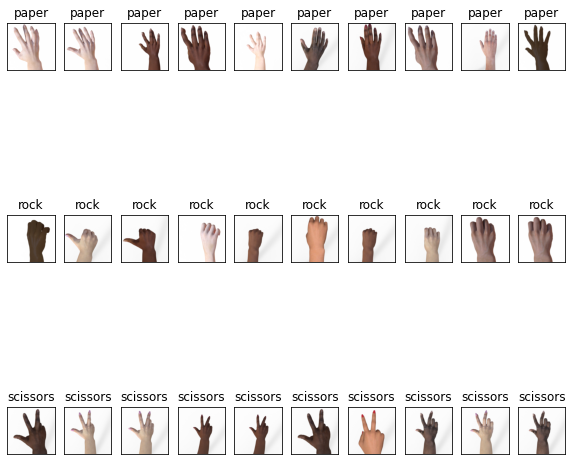

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

f, axarr = plt.subplots(3,10, figsize=(10,10))

i = 0
for dir_ in ['paper', 'rock', 'scissors']:
    for img in os.listdir(f'data/{dir_}')[:10]:
        subplot = axarr[i // 10, i % 10]
        subplot.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
        subplot.imshow(imread(f'data/{dir_}/'+img))

        subplot.title.set_text(dir_)
    
        i += 1  
    

### Checking the images sizes

In [ ]:
sizes = set()
for dir_ in ['paper', 'rock', 'scissors']:
    for file in os.listdir('data/'+dir_):
        sizes.add(imread('data/'+dir_+'/'+file).shape)
        
sizes


{(300, 300, 4)}

So we have only one size in the training set

### Make a training and validation set

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split = 1-2048/2532)#, rotation_range = 20, brightness_range = (0.0,10.0), zoom_range=(0,10))

# Flow images in batches of 64 using train_datagen generator
train_generator = datagen.flow_from_directory(
        '../content/drive/MyDrive/data/',  # This is the source directory for training images
        target_size=(300, 300), 
        batch_size=64,
        class_mode='categorical',
        subset='training')

validation_generator = datagen.flow_from_directory(
        '../content/drive/MyDrive/data/',  # This is the source directory for training images
        target_size=(300, 300),  
        batch_size=64,
        class_mode='categorical',
        subset='validation')


Found 2048 images belonging to 3 classes.
Found 483 images belonging to 3 classes.


If you need to verify that the labels are provided in one-hot encoded format, you can run the below cell

In [ ]:
#next(train_generator)[1]

### Build a custom model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', 
           input_shape = (300,300,3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #Conv2D(64, (3,3), activation='relu'),
    #MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax', name = 'output_layer_3_probas')
], name='rock_paper_scissors')


In [ ]:
model.summary()

Model: "rock_paper_scissors"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 170528)            0         
                                                                 
 dense_2 (Dense)             (None, 64)        

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

Let's train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 2)

In [ ]:
history = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=5,
      callbacks=[es],
      #use_multiprocessing=True,
      steps_per_epoch=32,
      validation_steps=32)


Epoch 1/5
32/32 [==============================] - 138s 4s/step - loss: 3.9906 - acc: 0.3438 - val_loss: 1.1107 - val_acc: 0.3810
Epoch 2/5
32/32 [==============================] - 113s 3s/step - loss: 1.0865 - acc: 0.3809
Epoch 3/5
32/32 [==============================] - 99s 3s/step - loss: 1.0894 - acc: 0.3867
Epoch 4/5
32/32 [==============================] - 101s 3s/step - loss: 1.0609 - acc: 0.3804
Epoch 5/5
32/32 [==============================] - 104s 3s/step - loss: 1.0675 - acc: 0.3813


Baseline: 1/3 (33.3%) so the model is as expected really poor right now. We'll use transfer learning to boost the performance

In [ ]:
!ls predictions/

paper1.png  paper-hires1.png  rock8.png        scissors6.png
paper2.png  paper-hires2.png  rock9.png        scissors7.png
paper3.png  rock1.png	      rock-hires1.png  scissors8.png
paper4.png  rock2.png	      rock-hires2.png  scissors9.png
paper5.png  rock3.png	      scissors1.png    scissors-hires1.png
paper6.png  rock4.png	      scissors2.png    scissors-hires2.png
paper7.png  rock5.png	      scissors3.png
paper8.png  rock6.png	      scissors4.png
paper9.png  rock7.png	      scissors5.png


In [ ]:
import numpy as np
from keras.preprocessing import image


# predicting images
path = 'predictions/paper1.png'
img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)
image = np.vstack([x])
classes = model.predict(image, batch_size=10)
print(classes)


[[0.37188393 0.38535643 0.24275962]]


### Using transfer learning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    
    model = VGG16(include_top=False,
    weights='imagenet',
    input_shape=(300,300,3),
    classifier_activation='softmax'
)

    
    return model

In [ ]:
model = load_model()

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
def set_nontrainable_layers(model):
    for layer in model.layers:
        layer.trainable = False
    return model

model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
base_model = load_model()
base_model = set_nontrainable_layers(base_model)
flattening_layer = Flatten()
dense_layer = Dense(256, activation='relu')
prediction_layer = Dense(3, activation='softmax')

model = Sequential([
  base_model,
  flattening_layer,
  dense_layer,
  prediction_layer
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               10617088  
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 25,332,547
Trainable params: 10,617,859
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)

In [ ]:
model.compile(metrics=['accuracy'], loss = 'categorical_crossentropy', optimizer=optimizer)

Set up 2 useful callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(patience = 2)
model_checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoints',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Need to preprocess input like it was preprocessed for VGG16 training?

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input



In [ ]:
history = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=3,
      callbacks=[es, model_checkpoint_callback],
      use_multiprocessing=True,
      steps_per_epoch=32,
      validation_steps=32)


Epoch 1/3
32/32 [==============================] - 49s 2s/step - loss: 0.2381 - accuracy: 0.9214 - val_loss: 0.0404 - val_accuracy: 1.0000
Epoch 2/3
32/32 [==============================] - 43s 1s/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 3/3
32/32 [==============================] - 44s 1s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 1.0000


Test the model on random, unseen images

In [ ]:
path = '../content/drive/MyDrive/predictions/'
len(os.listdir(path))

33

In [ ]:
from keras.preprocessing import image


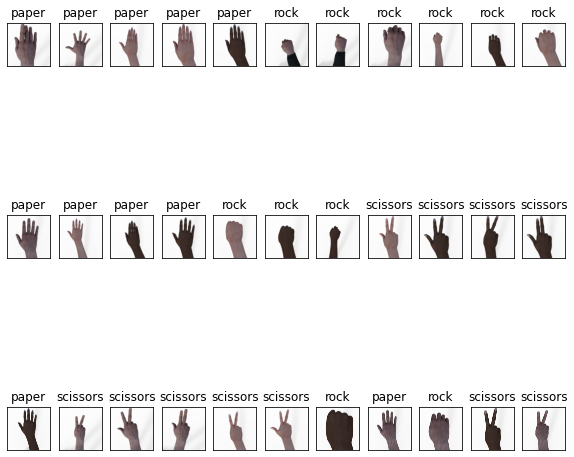

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from matplotlib.image import imread

# predicting images
test_images_path = '../content/drive/MyDrive/predictions/'


def load_preproc_img(path: str):
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  image = np.vstack([x])
  return image


f, axarr = plt.subplots(3,11, figsize=(10,10))

i = 0
for path in os.listdir(test_images_path):
  img_path = test_images_path+ path
  subplot = axarr[i // 11, i % 11]
  subplot.tick_params(left = False, right = False , labelleft = False ,
              labelbottom = False, bottom = False)
  subplot.imshow(imread(img_path))
  pred = model.predict(load_preproc_img(img_path))
  subplot.title.set_text(['paper', 'rock', 'scissors'][np.argmax(pred)])
  i += 1  






### Save the model for later use in the app

In [ ]:
from tensorflow.keras.models import save_model, load_model

# Let's say that you have a `model`
# You can save it:
save_model(model, 'rock_paper_scissors_CNN.h5')



### Copy the model onto my Google Drive

In [ ]:
! cp ../content/rock_paper_scissors_CNN.h5 ../content/drive/MyDrive/ -r

### Test loading the model

In [ ]:
m = load_model('../content/rock_paper_scissors_CNN.h5')

In [ ]:
m.weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
    

## Deploy it on a live cam app using opencv